100%|██████████████████████████████████████████████████████████████████| 800/800 [00:21<00:00, 36.62it/s, ELBO=-1155.43]


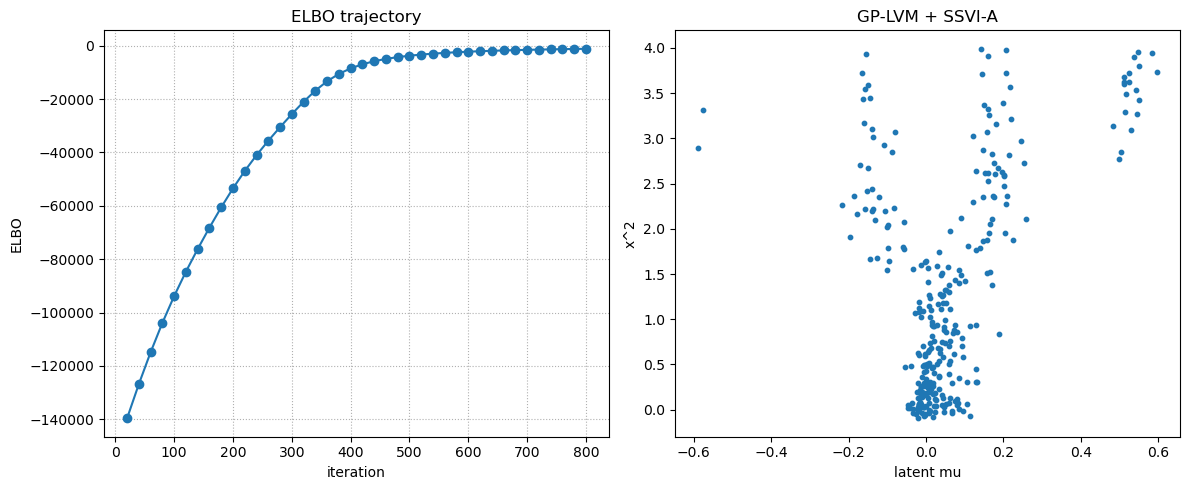

In [5]:
# ================================================================
#  GP-LVM  (toy, D=2)  +  Stochastic Structured VI-A
# ================================================================
import math, torch, tqdm, matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

# --------------------- synthetic data ---------------------------
N  = 300
x0 = torch.linspace(-2, 2, N, device=dev).view(N, 1)
y  = torch.cat([x0**2, torch.sign(x0)], 1)          # (N,2)
y += 0.05 * torch.randn_like(y)                     # noise
D, Q = y.shape[1], 1

# --------------------- inducing points & kernel -----------------
M             = 15
Z             = torch.linspace(-2.5, 2.5, M, device=dev).view(M, 1)
log_sigma2    = torch.tensor(0.0,  device=dev, requires_grad=True)
log_alpha     = torch.tensor(0.0,  device=dev, requires_grad=True)

def se_kernel(x, z, ls2, alpha):
    diff2 = (x - z.T).pow(2)
    return ls2.exp() * torch.exp(-0.5 * alpha.exp() * diff2)

def rebuild_kmm(ls2, alpha):
    Kmm = se_kernel(Z, Z, ls2, alpha)
    return Kmm + 1e-6 * torch.eye(M, device=dev)

# --------------------- q(U) params ---------------------------
m_u     = torch.zeros(D, M, device=dev, requires_grad=True)
log_s2u = torch.full((D, M), -3.0, device=dev, requires_grad=True)

def sample_U():
    eps = torch.randn_like(m_u)
    return m_u + eps * torch.exp(0.5 * log_s2u)

# --------------------- q(x) params ---------------------------
mu_x    = torch.zeros(N, Q, device=dev, requires_grad=True)
log_s2x = torch.zeros(N, Q, device=dev, requires_grad=True)
inner_opt = torch.optim.Adam([mu_x, log_s2x], lr=1e-2)

# --------------------- optimizer for hyperparams and q(U) ------------
outer_opt = torch.optim.Adam([m_u, log_s2u, log_sigma2, log_alpha], lr=2e-3)

# --------------------- ELBO terms -------------------------------
beta_inv = math.exp(-4.)

def compute_local_terms(idxs, U, mu_x_now, log_s2x_now, ls2_kernel, alpha_kernel):
    Kmm = rebuild_kmm(ls2_kernel, alpha_kernel)
    Kin = torch.cholesky_inverse(torch.linalg.cholesky(Kmm))

    mu, s2 = mu_x_now[idxs], log_s2x_now[idxs].exp()  # (S,1)
    psi1 = se_kernel(mu, Z, ls2_kernel, alpha_kernel)  # (S,M)
    psi2 = psi1[:,:,None] * psi1[:,None,:]  # (S,M,M)
    psi0 = ls2_kernel.exp()

    A  = (Kin @ psi1.T).T  # (S,M)
    f_mu = A @ U.T       # (S,D)

    sigma_2_hat = beta_inv + psi0 - torch.einsum('mi,sij,mj->s', Kin, psi2, Kin)
    sigma_2_hat = sigma_2_hat.clamp_min(1e-9)

    loglike = (-0.5 * math.log(2 * math.pi) 
               - 0.5 * sigma_2_hat.log()[:,None]
               - 0.5 * (y[idxs] - f_mu).square() / sigma_2_hat[:,None]).sum(-1)

    kl_x = 0.5 * (s2 + mu.pow(2) - s2.log() - 1).sum(-1)
    return (loglike - kl_x).mean()

def compute_KL_U():
    Kmm = rebuild_kmm(log_sigma2, log_alpha)
    Kin = torch.cholesky_inverse(torch.linalg.cholesky(Kmm))
    S2u = log_s2u.exp()
    tr_term = (Kin.diag().unsqueeze(0) * S2u).sum()
    quad_term = (m_u @ Kin * m_u).sum()
    logdet_p = D * torch.logdet(Kmm)
    logdet_q = log_s2u.sum()
    return 0.5 * (tr_term + quad_term - D*M + logdet_p - logdet_q)

def full_ELBO():
    idxs = torch.arange(N, device=dev)
    U_now = sample_U().detach()
    return compute_local_terms(idxs, U_now, mu_x, log_s2x, log_sigma2.detach(), log_alpha.detach()) - compute_KL_U()

# --------------------- main algorithm ----------------------------
T = 800
batch = 128
inner_steps = 5

full_log, steps = [], []

pbar = tqdm.trange(1, T+1, ncols=120)
for t in pbar:

    idx = torch.randint(0, N, (batch,), device=dev)

    # ======== E-step: update q(x) ========
    for _ in range(inner_steps):
        U_e = sample_U().detach()   # New sample every inner step
        inner_opt.zero_grad(set_to_none=True)
        loss_e = compute_local_terms(idx, U_e, mu_x, log_s2x, log_sigma2.detach(), log_alpha.detach())
        (-loss_e).backward()
        inner_opt.step()
        mu_x.detach_().requires_grad_()
        log_s2x.detach_().requires_grad_()

    # ======== M-step: update q(U) and hyperparams ========
    outer_opt.zero_grad(set_to_none=True)
    U_m = sample_U()
    loss_m = compute_local_terms(idx, U_m, mu_x, log_s2x, log_sigma2, log_alpha) - compute_KL_U()
    (-loss_m).backward()
    outer_opt.step()

    # Restrictions on log-hyperparams
    with torch.no_grad():
        log_sigma2.clamp_(-8, 4)
        log_alpha.clamp_(-8, 4)

    if t % 20 == 0:
        elbo_now = full_ELBO()
        full_log.append(elbo_now.item())
        steps.append(t)
        pbar.set_postfix({'ELBO': f'{elbo_now:.2f}'})

# --------------------- plots -----------------------------------
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(steps, full_log, '-o')
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('ELBO')
ax[0].grid(ls=':')
ax[0].set_title('ELBO trajectory')

ax[1].scatter(mu_x.detach().cpu(), y[:,0].cpu(), s=10)
ax[1].set_xlabel('latent mu')
ax[1].set_ylabel('x^2')
ax[1].set_title('GP-LVM + SSVI-A')

plt.tight_layout()
plt.show()
